### Machine Learning Pipeline

Bu bölüm sonunda gelmeyi hedeflediğimiz nokta buradaki işlemleri otomatik şekilde yapabilmek, script level/işletim düzeyinde çeşitli python makine öğrenmesi görevlerimizi çalıştırabilmeyi, kullanabilmeyi öğrenmek olacaktır. 

##### DIABETES RESEARCH

In [1]:
################################################
# End-to-End Diabetes Machine Learning Pipeline I
################################################

# 1. Exploratory Data Analysis
# 2. Data Preprocessing & Feature Engineering
# 3. Base Models
# 4. Automated Hyperparameter Optimization
# 5. Stacking & Ensemble Learning
# 6. Prediction for a New Observation
# 7. Pipeline Main Function

import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

#### Keşifçi Veri Analizi ( EDA )

**DİKKAT :** Çalışmalarımız esnasında orta ileri seviye iş ihtiyaçları için bir tane çalışma dosyamız, bir tane de bunu scriptlere çevirdiğiöiz yani sadece kodların olduğu bir yapıya çevirdiğimiz kod dosyamız olabilir. Yani burada research yok. Şunun görseline bakayım, şu değişkenleri inceleyeyim buna göre şu adımı atayım falan filan gibi işler yoktur. Artık bu araştırma bölümünde tamamlamışolduğumuz genel çerçeveyi fonksiyonlarca tanımlıyor oluruz.

Bu her iş ihtiyacı için ortaya çıkmıyor olabilir.

In [2]:
################################################
# 1. Exploratory Data Analysis
################################################

# Bu bölümde bol bol fonksiyonlarla ilgileniyor olacağız.

# Bir dataframe sorduğumuzda bunun shape bilgisini tip bilgisini head'ini tail'ını baştan ve sondan bir göz atma işlemini, eksik
# değerlerini, sayısal değişkenlerin quantile'larını göstermeye yarar.
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

    
# Bir kategorik değişkeni ve bir dataframe'i verdiğimizde o kategorik değişkenin sınıf frekasını ve sınıflarının oranını ifade 
# ediyor. Eğer plot argümanını True yaparsak bu durumda ilgili değişken için sütun grafik de oluşturuyor. Kategorik değişken 
# özetleme fonksiyonu olarak dğerlendirebiliriz.
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)



# Sayısal değişkenleri özetlemek için kullanacağımız fonksiyon. Aslında klasik bir describe işlemi gerçekleştirir. 
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


# Bağımlı değişkeni sayısal bir değişkenle özetlemek için kullanacağımız fonksiyondur. Bağımlı değişkene göre groupby'a alıyoruz
# ve sayısal değişkenin ortalamasını alıyoruz.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


# Bağımlı değişkeni kategorik değişkenle özetlemek istediğimizde kullandığımız fonksiyondur. Kategorik değişkene göre groupby'a 
# alıp bağımlı değişkenin ortalamasını alıyoruz.
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

    
# Keşifçi veri analizinde ele aldığımız bazı konular vardı. Genel resme bak, kategorik değişkenleri özetle, sayısal değişkenleri
# özetle, bağımlı değişkenler ile diğer değişkenleri çaprazla gibi işlemler vardı. Bir de aşağıda korelasyon matrisini 
# oluşturmak için bir fonksiyonumuz vardır. Özetle veri setinin içerisindeki sayısal değişkenlerin birbirleri arasındaki 
# korelasyonu hesaplıyor olacak ve bunu bir ısı haritası yardımıyla görselleştiriyor olacak.
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

    
# Elimiz ayağımız ve sürekli kullanacağımız bir fonksiyondur. Kategorik değişkenleri, sayısal değişkenleri ve kategorik gibi
# gözüken cardinal değişkenleri bize veriyordu. Kategorik değişkenlerin içerisinde sayısal gibi gözüken ama sınıf sayısı 
# azlığından dolayı bizim kategorik değişken muamelesi yaptığımız kategorik değişkenler de vardı. 
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

# Bunları pipeline'da bir çoğunu kullanmıyor olacağız. Research'ümüzü tamamlamış olacağız. Burada kararlarımızı verip sonraki
# adıma nihai olarak geçiyor olacağız. Bu noktada sadece grab_col_names bizimle geliyor olacaktır.

In [3]:
# Diyabet veri setini okutalım:
df = pd.read_csv("datasets/diabetes.csv")

check_df(df)

# NA kısmındaki bazı 0'lar iş bilgisi açısından anlamsızdır. Kan basıncı 0 olamaz. Bu nedenle verideki bu 0'lar muhtemelen NA 
# değerlerin 0 ile doldurulmuş halidir. Burayı ana odağımızdan kopmamak adına pas geçiyoruz.

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [4]:
# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
# eşsiz değer sınıfını yani cat threshold'u 5 olarak belirledik. Bu bizim kararımıza bağlıdır.

# cat_th değerini 10 yapıp bir gözlemlemek istersek bir değişiklik olmadığını görürüz. Fakat bunu neden yaptığımızı soracak 
# olursak ilerleyen bölümlerde yeni featurelar türetmiş olacağız. Bu üretmiş olduğumuz yeni featurelarda yeni kategorik 
# değişkenler gelecek. Mesela BMI, age değişkenlerini parçalayacağız. Kategorik değişkene çevireceğiz. Bu durumda 5 sınıftan az 
# olduğu için durumunu tekrardan bir gündeme almak istedik. Tabi bunları sayısalları kategoriğe değiştirdiğimizde ortada böyle
# bir ihtiyaç olmayacak ama türeyebilecek diğer başka olası değişkenler için kendimizce bu veri setini tanıdığımızdan dolayı
# böyle bir karar alıyoruz. 10 olarak bırakabiliriz de ancak bu değiştirilebilen bir özellik şu an bunu 5 olarak yapmayı tercih
# ediyoruz.

In [5]:
cat_cols

['Outcome']

In [6]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [7]:
cat_but_car

[]

In [8]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

   Outcome      Ratio
0      500  65.104167
1      268  34.895833
##########################################


In [9]:
# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

# for col in num_cols:
#     num_summary(df, col, plot=True)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


**Insulin'in max değeri olan 846'da sanki bir anormallik var. Diğerlerinde çok çok ciddi göze batan bir durum yok gibi gözüküyor.**

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


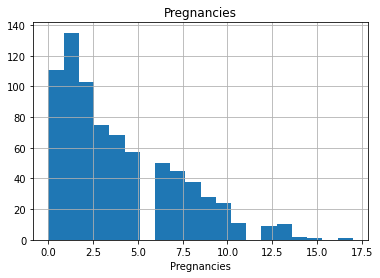

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


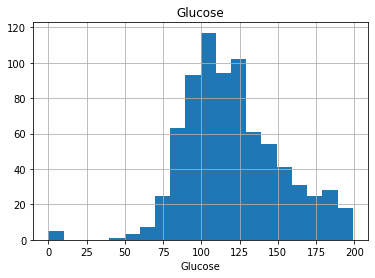

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


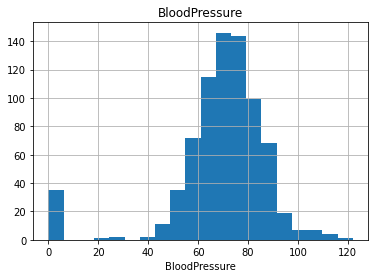

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


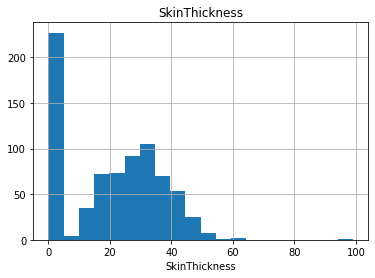

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


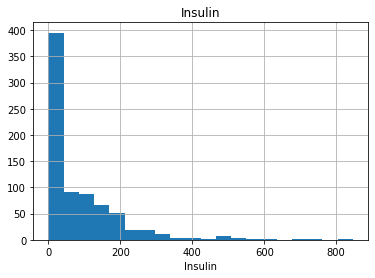

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


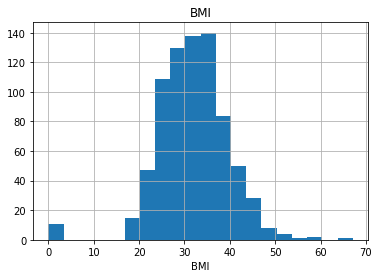

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


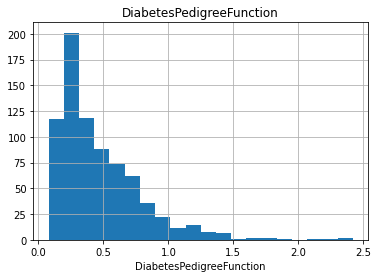

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


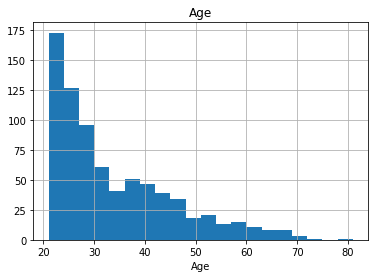

In [10]:
# Sayısal değişkenlerin bir grafiğini oluşturmak istersek ki bu EDA kapsamında yapmamız gerekebilecek bir işlemdir. Genel gidişi
# görebilmek için buraya bir göz atıyoruz. Kodu tekrar çalıştırdığımızda burada zaman kaybedilmemesi adına Vahit Hoca burayı
# yorum satırına almamızı öneriyor. Alacağımızı aldıktan sonra commentlemek en doğrusudur.
for col in num_cols:
    num_summary(df, col, plot=True)

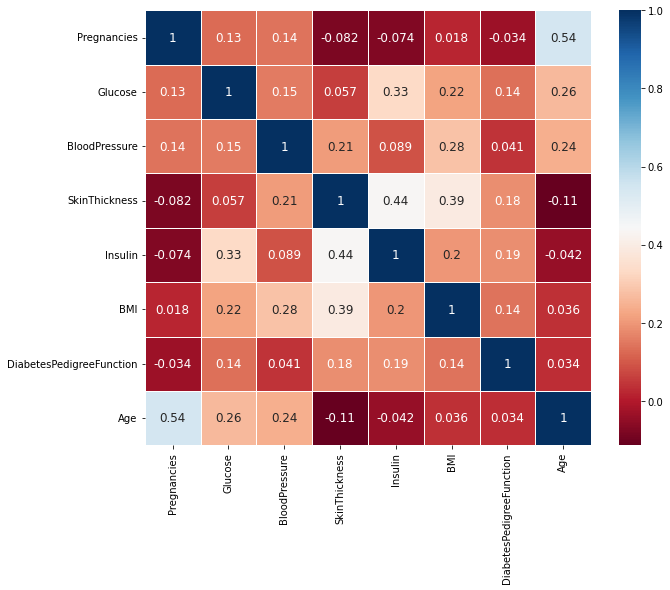

In [11]:
# Sayısal değişkenkerin (çok değişkenli olarak) birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

# Bu ısı haritası negatif ve pozitif korelasyonu ifade ediyor. 1 pozitif yüksek korelasyonu, -1 negatif yüksek korelasyonu 
# gösterir.
# Gözümüze çarpan şey hamilelik ve yaş arasında orta şiddetli pozitif bir ilişki var gibi gözüküyor. Bu sezgilerimize uygundur.
# Yaş arttıkça hamilelik sayısının artmasını bekleriz. Pozitif veya negatif yönlü başka dikkate değer yani %40 üzeri bir 
# korelasyon 2 yönlü de olabilecek bir başka korelasyon var mı diye bakıyoruz. İnsülin ile deri kalınlığı arasında 0.44 birim
# bir korelasyon var. Yani pozitif orta zayıf şiddetli bir ilişki var gibi gözüküyor.

In [12]:
# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




**SONUÇ :** Neyi anlıyoruz burada? Veri seti yaklaşık 800 tane gözlem biriminden oluşan, çoğu sayısal değişkenlerden olan, sayısal değişkenlerde genel hatları itibari ile çok problem olmadığı kanaatinde olduğumuz sadece insülin değişkeninde sanki bir aykırılık var gibi gözlemlediğimiz bir yapıdır. Bununla beraber yeni değişken üretilmesini mümkün bazı diğer değişkenler var ve NA'lere 0 denilmiş galiba ön bilgimiz vardır. Genel hatları itibari ile veri setimizi tanıdık. Burada alınabilecek aksiyonları biliyoruz. Aykırı değerleri bir inceleyebiliriz. Yeni değişkenler üretebiliriz, mutlaka ve mutlaka üretmeliyiz. Bu üretme işi için literatüre bakabiliriz. Direkt bildiğimiz bu diyabet ile ilgili sağlık literatürüne bakıp nelerin diyabeti etkilediğini inceleyip onların bu veri setinde sağlanıp sağlanmadığını değerlendirip veri setine değişken olarak eklemeyi düşünebiliriz. 

### Veri Ön İşleme ( Data Pre-Processing )

In [13]:
################################################
# 2. Data Preprocessing & Feature Engineering
################################################

# Bu fonksiyonun görevi kendisine girilen bir değişkenin alt ve üst eşik değerlerini hesaplamaktır. Bunu boxplot yöntemiyle 
# diğer bir ifadeyle iqr yöntemi ile yapmaktadır. Ön tanımlı değerleri q1 için 0.25 q3 için 0.75'tir. Bunun üzerinden 1.çeyrek 
# değerinden 1.5 iqr aşağı inilir. 3.çeyrek değerinin 1.5 iqr üzerine çıkılır. iqr interquartile range ifadesidir. Yani 3.çeyrek
# ile 1.çeyreğin farkıdır. Bir değişken için bu eşik değerler hesaplandıktan sonra herhangi bir değişkendde aykırı değer var mı
# yok mu sorusunu sorabiliriz ya da direkt aykırı değer barındıran bir değişkenin bu aykırı değerini gönder bu threshold 
# değerini koy diyebiliriz. Dolayısıyla aykırı değer için outlier_thresholds, replace_with_threshholds ve check_outlier'ı
# kullanıyor olacağız.

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


# Bununla beraber bir one_hot_encoder'ımız var. Hiç kategorik değişken yok ki bunu niye kullanacağız diyorsak yeni değişkenler 
# türeteceğiz ve bu türettiğimiz değişkenlerde yeni kategorik değişkenler olacaktır. Bundan dolayı one_hot_encoder'ı kullanıyor
# olacağız. one_hot_encoder'ı aynı zamanda label_encoder olarak da kullanabilmek için drop_first argümanını True yaptık. Aslında
# pandas içerisindeki get_dummies metodunu kullanıyor olacağız. Kategorik değişken listesini verdiğimizde drop_first=True 
# dediğimizde bize 2 sınıflı kategorik değişkenleri de label_encoder'a sokabiliyor olacak. Bizim için 2 sınıflı kategorik  
# değişkenleri label_Encoder'a sokabiliyor olacak. Yani ilk sınıfı drop ettiğinde dummy değişken tuzağından kurtuluyor olacak. 
# Özetle iki sınıfa ya da daha fazla sınıfa sahip olan kategorik değşkenleri sadece one_hot_encoder fonksiyonumuzu kullanarak 
# biçimlendirebiliyor olacağız.
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
# Glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])
# bins=[-1, 139, 200] yazılmasının sebebi burada 0 yazmak yerine 0'ı da kapsaması düşüncesiyle -1 yazdık. Herhangi bir ek görevi
# yok yani.

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal


NEW_GLUCOSE_CAT değişkenini var olan bir değişken üzerinden türettik. Peki bu var olan eski değişkeni silmeli miyiz? Hayır silmemeliyiz. Şimdilik ama. 

**DİKKAT :** Çok kritik bir noktadayız. İyice bir detaylara girmeden boğulmadan önce hemen bunu bir ele alalım. Hatırlayalım ağaç yöntemleri bölümünde bir sayısal değişken üzerinden yeni bir kategorik değişken oluştruduğumuzda bu ağacın çalışma performansını pozitif etkileyebilir yorumu yapmıştık ve dikkat edilmesi gereken çok sinsi bir problem olduğunu ifade etmiştik. O da şimdi normalde biz bins=[-1, 139, 200] aralığına göre değişkeni ikiye böldük ama belki ağacın bölünme sürecini hatırlayalım mesela belki Glucose 85'değerinden böldüğümüzde daha iyi bir homojenlik sağlanıyor olacak. Belki Glucose 137'den böldüğümüzde daha iyi bir homojenlik sağlanıyor olacak. Yani biz kendi elimizde zaten daha çeşitli daha zengin daha bilgi taşıyan ve daha olası senaryoya göre homojenliği sağlayabilecek bir değişkeni kendi elimizle bozmuş oluyoruz. Diğer yandan bu yeni oluşturulan değişken Glucose'un direkt tüm taşıdığı bilgiyi taşımıyor onun içerisinde var olan iki sınıfı aslında ona referans alarak oluşturuyor. Buralar önemli noktalardı. Yani biz eğer şunu yapsaydık: Glikozu 1 ile 5 arasında sayılara çevirseydik veya buradaki bins=[-1, 139, 200] ölçek türünü değiştirseydik bu biraz daha ona yakın olur ve korelasyonu yüksek çıkardı. Ama zaten bunun üzerinden yeni bir dğeişken oluşturduk ve kapsayacılığı çok düşük 2 sınıf oluşturduk. Dolayısıyla bunu şimdilik silmiyoruz. Peki hiç mi silmeyeceğiz? Burası yine bir karar noktasıdır. Ağaç yöntemlere gittiğimizde ya da çeşitli feature importance yöntemleri kullandığımızda o noktada karar verebiliriz. Ama glikoz bizim için çok yüksek olasılıkla önemli olacak bir değişken onun üzerinden bir değişken oluşturduk diye onu hemen şimdi silmeye karar vermiyoruz. Bir gözlemleyelim bakalım. Bleki new_glucose_cat değşkeni anlamsız bir değişken olacak, belki hiç bilgi taşımayacak. Neden şimdi silelim? Dolayısıyla bunu silip silmeme işine karar vermek için acele etmiyoruz. Modelleme basamağına gitmeyi bekliyoruz.

In [16]:
# Age : Yaş değişkeni üzerinden değişken oluşturalım:
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'


# BMI
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])

# DİKKAT : Biz kendimiz bir makine öğrenmesi modeli geliştirme sürecinde, değişken mühendisliği sürecinde eğer yeni değişkenler
# oluşturuyorsak. Bunları çalışmanın kapsamında takip edebilmek düşüncesiyle başlarına new isimlendirmesi yapıyoruz. Dolayısıyla
# eğeristersek bu şekilde ilerlenebilir.


# BloodPressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

Burada bu değişkenlerin hepsi var olan dğeişkenlerin üzerinden çok büyük umutlarla oluşturduğumuz değşkenler değil sadece burada makine öğrenmesi sürecinin iki taraflı olduğunu görebilmemiz içn bu değişkenleri ekledik. Yani veri ön işleme kapsamında ve EDA kapsamında yaptığımız işler research adı altında birbirini iki taraflı etkilemektedir. Nasıl yani? Evet dikkat, çok kritik bir noktadayız. Daha önce grab_col_names'i kullanarak ne yapmıştık, kategorik, nümerik ve kardinal değişkenleri getirmiştik. Onlar cepteydi, programatik olarak artık üzerlerinde çalışabiliyorduk. Eee ama şimdi yeni değişkenler oluşturduk. Ne yapmamız lazım? Bunlar çok sinsi problemlerdir. Programatik olarak gitmenin sinsi problemleridir. Ne yapmamız lazım, bir daha oluşturmamız lazımdır ve diğer yandan check_df diyerek buradaki problemi var mı yok mu diye kontrol ediyor olmamız lazım.

In [17]:
check_df(df)

# Bakıyoruz bir problem yok gibi gözüküyor. Eğer bu -1 ifadesini koymamış olsaydık burada çeşitli problemlerle karşılaşıyor 
# olacaktık. Bazı NA'ler türemiş olacaktı. Daolayısıyla aslında check_df'İn önemli bir görevi bir kod akışı esnasında belirli 
# bir noktayı geçtiğimizde her şey yolunda mı sorgusunu yapmaktır. Her şey yolunda gibi gözüküyor. grab_col_names'i tekrar
# çağırıyoruz çünkü artık yeni değişkenlerimiz var.

##################### Shape #####################
(768, 13)
##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_GLUCOSE_CAT             category
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME NEW_GLUCOSE_CAT NEW_AGE_CAT NEW_BMI_RANGE NEW_BLOODPRESSURE
0            6      148             72             35        0  33.6                     0.627   50        1     prediabetes   middleage         obese            normal
1       

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

cat_cols
# Görüldüğü gibi yeni değişkenler var. Değişken mühendisliği bölümünde yeni feature'lar eklememizin en büyük sebebi bu iki 
# taraflı sürekli birbirini etkileyen ve etkileşimlerin farkında olmamızı sağlamaya çalışmaktır.

['NEW_AGE_CAT',
 'OUTCOME',
 'NEW_GLUCOSE_CAT',
 'NEW_BMI_RANGE',
 'NEW_BLOODPRESSURE']

In [19]:
num_cols
# Bir değişiklik yok.

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

In [20]:
cat_but_car
# Bir değişiklik yok.

[]

In [21]:
for col in cat_cols:
    cat_summary(df, col)

           NEW_AGE_CAT      Ratio
young              488  63.541667
middleage          230  29.947917
old                 50   6.510417
##########################################
   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
##########################################
             NEW_GLUCOSE_CAT      Ratio
normal                   571  74.348958
prediabetes              197  25.651042
##########################################
             NEW_BMI_RANGE      Ratio
obese                  472  61.458333
overweight             179  23.307292
healty                 102  13.281250
underweight             15   1.953125
##########################################
        NEW_BLOODPRESSURE      Ratio
normal                563  73.307292
hs1                   145  18.880208
hs2                    60   7.812500
##########################################


In [22]:
# Burada yeni değişkenler oluşturduk ya şunu merak ediyoruz: Acaba bağımlı değişken ile bu yeni değişkenlerin ilişkisi ne 
# şekilde?
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                  0
1                  1


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




In [23]:
# OUTCOME'ı sen bağımlı değişkensin seni kategorik değişken listesinden bir çıkaralım diye düşünerek lsit comprehension ile 
# çıkaralım:
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]
cat_cols

# Şu an elimizdeki sadece bütün kategorik değişkenler vardır.

['NEW_AGE_CAT', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']

In [24]:
# Makine öğrenmesi modellerinin bizden beklediği bir standart vardı hatırlayalım. Bütün değişkenleri ya binary_encode etmemiz 
# gerekiyordu. Ya da sayısal bir formda ifade etmemiz gerekiyordu. Bu noktada elimizdeki bu kategorik değişkenlerle ilgili
# yapabileceğimiz bazı şeyler var, bu nokta da yine yoruma açık bir noktadır. Hemen olası alternatifleri konuşalım. Mesela 
# burada ['NEW_AGE_CAT', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE'] şeklinde oluşturduğumuz kategorik değişkenleri
# 1, 2, 3 şeklinde değerlerle temsil edip olduğu gibi bırakabiliriz, bunda bir problem yok çünkü zaten bu sınıflar büyüklük 
# küçüklüğü taşıyor olacak. Bu durumda hangi sınıfın büyük hangi sınıfın küçük olduğunu biliyor olmamız gerekecek. Bunu bilerek
# yani veriyi ilk oluşturduğumuz haldeki durumunu bilerek bunları sayısal değişkenlere label_encoding ile dönüştürebiliriz, bu
# bir tercih olabilir. Bir diğer tercih bunları one_hot_encoder'dan geçirmek olabilir. one_hot_encoder'dan geçirdiğimizde bir 
# değişkendeki sınıf sayısı kadar yeni kategorik değişken oluşuyor olacak ve böylece bunlar binary_Encode edilmiş olacak. Hemen
# gönderelim ve değerlendirmemizi yapalım:
df = one_hot_encoder(df, cat_cols, drop_first=True)
# drop_first'ü True yapıyoruz ki iki sınıflı olan kategorik değişkenlerin ilk sınıfı dışarıda kalmış olmasıyla dummy değişken
# tuzağından düşüyor olalım.

check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_old                  uint8
NEW_AGE_CAT_young                uint8
NEW_GLUCOSE_CAT_prediabetes      uint8
NEW_BMI_RANGE_healty             uint8
NEW_BMI_RANGE_overweight         uint8
NEW_BMI_RANGE_obese              uint8
NEW_BLOODPRESSURE_hs1            uint8
NEW_BLOODPRESSURE_hs2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  NEW_AGE_CAT_old  NEW_AGE_CAT_young  NEW_GLUCOSE_CAT_pr

In [25]:
# Değişken isimlerini tekrar büyütmeyi tercih edebiliriz.
df.columns = [col.upper() for col in df.columns]

check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PR

In [26]:
# Şimdi ilerlemeli miyiz ne yapmalıyız? one_hot_encoder'dan geçirdikten sonra bir sürü değişken geldi ama bunlar bizim 
# grab_col_names ile yanımızda taşıyor olduğumuz cat_cols listesinde yok ki. Bu noktadan kopmamak zorundayız. Bunları hep göz
# önünde tutuyor olmalıyız.

# Son güncel değişken türlerimi tutuyorum.
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols

['OUTCOME',
 'NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

In [27]:
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]
cat_cols

['NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

In [28]:
# Aykırı değerleri bir değerlendirelim:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))
# Yukarıdaki değerler hocanın subjektif bir yorumu, biz ön tanımlı değerleri (0.25-0.75) kullanabiliriz. Hoca bu değerleri neden
# kullanıyor dersek: Şimdi iqr yöntemi iyidir güzeldir fakat ufak bir dezavantajı vardır. Çok değişkenli etkiyi göz önünde
# bulunduramaz ki. Bu eğitimin ön gerekliliklerinden olan özellik mühendisliği eğitiminde bunları oldukça detaylı bir şekilde
# ele almıştık ancak kısa bir şekilde hatırlayalım. Örneğin bir yaş değişkeni olsun, bir hamilelik sayısı değişkeni olsun.
# Hamilelik sayısındaki 3 yaş değişkenindeki 17 sayısı tek başıan aykırı değer değildir. Ancak 17 yaşında 3 kere hamile kalmak 
# aykırı değerdir. Dolayısıyla çok değişkenli etki tek başına normalde aykırı olmayan bir durumu aykırı değe haline getirebilir.
# Bu sebeple iqr yani boxplot yöntemi değişkenlere tek başına baktığından dolayı çok değişkenli etkiyi kaçırabilir ön kabulüm 
# var. Bu sebeple karmaşık çok değişkenli yöntemleri de kullanmak istemediğimizden dolayı şöyle bir etliye sütlüye karışmayalım,
# aşırı aykırı olanları ucundan bir dokunalım, tıraşlayalım düşüncemizden dolayı böyle yapmayı tercih ettik. Öte yandan böyle
# yapmayabilirdik çünkü genelinde ağaç yöntemleri kullanacağız. Fakat bu uçtan uca süreç kapsamında birçok doğrusal modeli de 
# deniyor oacağımızdan dolayı bunlara ucundan bir dokunmayı tercih ettik.

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [29]:
# İnsülin değişkenindeki aykırı değerleri insülin değerinin threshold değeri ile değiştiriyor olacaktır.
replace_with_thresholds(df, "INSULIN")

# Tkerar çalıştıralım, aykırı değerden kurtulmuş olacağız.
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


**DİKKAT :** Uçtan uca bir uygulama ele alıyor olduğumuz için bölümler biraz uzun olacak. 

In [30]:
# Standartlaştırma
# İfade ettiğimiz gibi genel ilerleyişimiz ağaca dayalı yöntemler olacak olsa da burada şimdi bir pipeline oluştururken base 
# modelleri inceleyeceğiz. Yani gördüğümüz, görmediğimiz birçok modele fikrini soracağız. Bak bakalım sen de hzılı bir şekilde 
# bir modelle şunu diyeceğiz. Dolayısıyla mümkün olan en genel eğilimi gerçekleştirebilmek için standarylaştırma yapmayı tercih
# ediyoruz.
X_scaled = StandardScaler().fit_transform(df[num_cols])

# dataframe'imize geri atıyoruz:
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)


# Veri seti içerisinden y bağımlı değişkeni ve bağımsız değişkenleri seçmemiz lazım:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: OUTCOME, Length: 768, dtype: int64

In [31]:
X

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
0,0.639947,0.848324,0.149641,0.907270,-0.787602,0.204013,0.468492,1.425995,0,0,1,0,0,1,0,0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.787602,-0.684422,-0.365061,-0.190672,0,1,0,0,1,0,0,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.787602,-1.103255,0.604397,-0.105584,0,1,1,1,0,0,0,0
3,-0.844885,-0.998208,-0.160546,0.154533,0.217583,-0.494043,-0.920763,-1.041549,0,1,0,0,1,0,0,0
4,-1.141852,0.504055,-1.504687,0.907270,1.008900,1.409746,5.484909,-0.020496,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,1.137221,0.115169,-0.908682,2.532136,1,0,0,0,0,1,0,0
764,-0.547919,0.034598,0.046245,0.405445,-0.787602,0.610154,-0.398282,-0.531023,0,1,0,0,0,1,0,0
765,0.342981,0.003301,0.149641,0.154533,0.410066,-0.735190,-0.685193,-0.275760,0,1,0,0,1,0,0,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.787602,-0.240205,-0.371101,1.170732,0,0,0,0,0,1,0,0


In [32]:
# Son noktada bir problem olup olmaması açısından bir check etmemiz lazım:
check_df(X)

# Son adımda check etmek çok önemlidir. Genelde bir hata çıkar. Bu sorunlar bir NA türetmek veya değişkenlerin değerlerinin 
# bozulması gibidir. Şu anda bir problem yok gibi gözüküyor.

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_

In [33]:
# Yukarıda yaptığımız işlemleri bir fonksiyon haline de getirebiliriz.
def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

df = pd.read_csv("datasets/diabetes.csv")

check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [34]:
X, y = diabetes_data_prep(df)

check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_



**Şu anda bütün bu veri ön işleme aşamasını fonksiyonlaştırdık. Tek hamleyle tüm değişkenleri olması gereken hale getirdik.**


**DİKKAT :** Pipeline nedir? Pipeline bir boru hattı demektir. Uç uca boruları ekleyerek belirli bir aktarma işlemini temsil etmektedir. Şu anda pipeline'ımızın ilk borusunu döşemiş olduk. 

### Base Models

In [36]:
######################################################
# 3. Base Models
######################################################

# Research aşamasında da yer alabilir. Pipeline'da bir raporlama niyetiyle de yer alabilir ama genelde pipeline'da yer almaması
# gereken bir bölümdür. Yani research aşamasında temel bazı modellere bakılır. Bu modellerden bu problem için uygun olabileceği
# kanaatinde olunan 1 ya da birden fazla model seçilerek bu modellerin üzerinde hiperparametre optimizasyonları 
# gerçekleştiriliyor olur. Paratikte birçok senaryoda lightgbm gibi gelişmiş modeller en iyileri olur. Biz şöyle ilerliyor
# olacağız. Birçok temel modele ihtiyacımız olduğunda elimizin altında olsun düşüncesiyle bakıyor olacağız. Daha sonra temel
# modellerden aslında 1 tanesini seçip gitmek daha iyi olabilecekken biz 3 tanesini seçeceğiz. Bunun üzerinden bir stacking 
# diğer ifadesiyle bir ensemble learning yaklaşımı ile yan, 3 tane modele fikrini soracağız ve 3 modeli bir tahmin görevi için 
# birlikte kullanıyor olacağız şeklinde ilerleyerek yine olasıı bir ihtiyacımız durumunda nasıl ilerleyebileceğimizi görmüş
# olacağız.

# Fonksiyonun bir argümanı bağımsız değişkenlerken bir argümanı bağımlı değişkendir. scoring argümanında da ilgili test 
# istatistiği vardır. Bu fonksiyonu çalıştırdığımızda tüm modellere fikrinin sorulmasını ve temel hatalarına bak istiyoruz.
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   # Bazı hatalar çıktığı için use_label_encoder ve eval_metric argümanlarına bazı değerler atayarak sorunu 
                   # çözdük.
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   # catboost'u commentledik çünkü train işlemi çok uzun sürüyor. Zaman kaybetmemek açısından bunu yaptık.
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y)

Base Models....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6477 (CART) 
roc_auc: 0.827 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8255 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 


In [37]:
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6849 (CART) 
accuracy: 0.7695 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.75 (GBM) 
accuracy: 0.7448 (XGBoost) 
accuracy: 0.7383 (LightGBM) 


In [38]:
base_models(X, y, scoring="f1")

Base Models....
f1: 0.6233 (LR) 
f1: 0.6269 (KNN) 
f1: 0.6269 (SVC) 
f1: 0.5436 (CART) 
f1: 0.6287 (RF) 
f1: 0.637 (Adaboost) 
f1: 0.6139 (GBM) 
f1: 0.6289 (XGBoost) 
f1: 0.605 (LightGBM) 


### Automated Hyperparameter Optimization

In [39]:
######################################################
# 4. Automated Hyperparameter Optimization
######################################################

# Birden fazla modelin birden fazl arama görevini yine bir fonksiyon kullanarak otomatik bir şekilde gerçekleştirmeye 
# çalışacağız. Biz nihayetinde bir pipeline oluşturacağız. Bir Türkçe ifadesiyle boru hattı oluşturacağız. Bu pipeline'ın amacı
# bir makine öğrenmesi sürecini fonksiyonel bir formda belirli noktalardan müdahale edilebilir bir şekilde tanımlamaktır. Şimdi
# bir boru hattını düşünelim. Neden acaba fabrikalar tek bir plastik boru şeklinde bunu üretmiyor da bunları parça parça 
# üretiyor? Çünkü bu parçalar alınıp, sökülüp başka bir yere takılıp farklı farklı şekillerde kullanılabilir. Biz şöyle yapıyor
# oluyoruz, parçaları ayrı ayrı ufak ufak tanımlamanın alt yapısını hazırlıyoruz, veri ön işlemeyi tanımladık, hazırladık. Şimdi
# diğer bölümlere geçiyoruz. Burada birkaç farklı yol geliştiricinin tercih edebileceği bir şekilde biçimlenebilir. Örneğin
# bütün bir scripti tek bir dosyada tutabiliriz ya da biraz daha karmaşıklaştırmayı göze alarak eğer mümkün olduğu kadar 
# genellenebilir fonksiyonlarsa karmaşıklaştırmayı göze almak anlamlı olabilir çünkü başka ihtiyaçlar için de kullanılabilir ama
# genelde belirli bir makine öğrenmesi için oluşturulan pipeline o proje özelindedir, genellenebilirliği düşüktür. Bundan dolayı
# bütün o parça parça boruları ayrı ayrı scriptlerde tutup çağırmak ya da çağırmamak yine bir soru işaretidir. Aslında temelde
# ifade etmek istediğimiz bütün bu pipeline'ı tek bir python dosyası yani scriptinde oluşturabiliriz ya da bunları da aslında 
# ayrı ayrı python scriptlerinde oluşturabiliriz ve sonra bir scriptten bunları çağırabiliriz. Bu işi biraz karmaşıklaştırabilir
# farklı açılardan odağı arttırabilir. Dolayısıyla bunlar geliştiricinin kendi yaklaşımına kalmıştır. Biz bir arada kullanmayı
# tercih ediyoruz.

# knn için aramak yapmak istediğimiz parametre setini verelim:
knn_params = {"n_neighbors": range(2, 50)}

# cart için bir parametre seti verelim:
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

# rf için bir parametre seti verelim:
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

# xgboost için bir parametre seti verelim:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

# lightgbm için bir parametre seti verelim:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

# Bunların şu anda detayının bir önemi yok, başarısının yüksek yada düşük çıkmasının bir önemi yok. Amacımız sadece bu süreci
# gözlemlemek.


# Öyle bir işlem yapmalıyız ki modeller ve bu aranacak olan hiperparametreler bir arada olsun. Bunu gerçekleştirelim:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]


# Öyle bir fonksiyon içinde döngü yazmamız lazım ki raporlamak için isimleri alsın, modellemek için parametreleri alsın,
# defalarca gözlemlediğimiz hiperparametre optimizasyonunu otomatik şekilde hepsine uygulasın. 

# DİKKAT
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    
    # Hiperparametre optimizasyonunun başladığını belirten bir raporlama:
    print("Hyperparameter Optimization....")
    
    # Bir sözlük oluşturduk. Bu sözlüğün görevi buradaki en iyi modelelr olacak ya bu modelleri tutmaktır.
    best_models = {}
    
    # classifiers'ın içinde 3 tane indeks var, nedir bunlar? İşte buradaki name, classifier ve params ifadeleridir. 
    for name, classifier, params in classifiers:
        
        # Önce modelin ismini ekrana yazdırır.
        print(f"########## {name} ##########")
        
        # Daha sonra bu modelin henüz hiperparametre optimizasyonu yapılmadan önceki cross validation skoru hesaplanıyor.
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        
        # Aynı modelin bu hiperparametre optimizasyonu öncesindeki skoru/hatası ekrana yazdırılıyor.
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")
        
        # Daha sonra gridsearchscv devreye giriyor.
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        
        # Grid Search Best ile bir arama yapıldı. İlgili classifier'a gridsearchcv'den gelen en iyi paraöetreler set_params 
        # metoduyla set edilmiş, dolayısıyla final model oluşturulmuştur.
        final_model = classifier.set_params(**gs_best.best_params_)

        # Final modelin cross validation skoru gösterilmiş.
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        
        # İlgili model için hangi parametrenin belirlenmiş olduğu bilgisi raporlanmıştır. 
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        
        # best modellerin içerisine final model yerleştirilmiştir.
        best_models[name] = final_model
        
    return best_models

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6622
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8268
roc_auc (After): 0.8351
RF best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8179
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8185
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



### Stacking & Ensemble Learning

In [40]:
######################################################
# 5. Stacking & Ensemble Learning
######################################################

# Temeli birden fazla modeli bir arada kullanmaya dayanmaktadır. Ensemble learning topluluk öğrenme yöntemi kapsamında aslında 
# random forest'a daha özelinde random forest'ın temelini oluşturan bagging'de gündemimize girmişti. Birden fazla ağaç bir araya 
# gelerek tek bir ağaç, bir meclis gibi hareket ediyordu ve hepsi tahminlerde bulunduğunda bu tahminler bir araya getirilerek
# değerlendiriliyordu. Buradaki bir algoritmanın kenid içindeki çalışma prensibi yerine birden fazla algoritmanın bir araya 
# gelerek bu işlemleri yapması işlemlerine stacking learning, ensemble learning, meta learning gibi isimlendirmeler 
# yapılmaktadır. Yani özetle diyeceğiz ki knn, random forest, gbm, lightgm gelin bakalım, birleşmiş milletler burası, hepiniz 
# bir model kurun, hepiniz bir tahminde bulunun, ben hepinizi biz araya getiriyoruz, bir tahmin görevini birlikte yerine 
# getiriyor olacağız. Bir gözlem birimi geldiğinde bu gözlem birimini birlikte tahmin ediyor olacağızdır. Dolayısıyla aslında
# tahmin performansını güçlendirmesini beklediğimiz. Çünkü örneğin lightgbm'in dallara ayırma yaklaşımındaki farklılığı
# hatırlayalım. Lightgbm farklı bir açıdan yaklaşıyorken randomforest farklı bir açıdan yaklaşabiliyordu. Dolayısıyla bu noktada
# bu yöntemlerin kendince iyi açıklayabilmiş olabileceği bazı yönler olmuş olabilir. Bu hepsinin gücünü bir araya getirerek 
# tahminde bulunma işlemini gerçekleştiriyor olacağız.

# Bunun diğer isimlendirmesi voting yani oylamadır. Bunun regresyon ve sınıflandırma hali de vardır. Şu anda biz sınıflandırma
# halini kullanıyor olacağız. Aşağıda sınıflandırıcılarla ilgili oylama yapılacağını ifade eden bir cümle (ilk cümle) var.
# Bir soft vote kavramımız var bir de hard vote kavramımız vardır. Ön tanımlı değeri hard'tır. Hard en fazla olan sınıfı ifade
# eder. Yani diyelim ki 3 tane yöntemimiz var, 3 tane model var. Üçüne de fikrini sorduk. Bir sınıflandırma modeli için.
# Diyelim ki 2 tanesi 1, 1 tanesi 0 dedi. O zaman en fazla oyu alan sınıf 1 olduğu için tahmini sonucumuz 1'dir diyoruz. 
# Oylamanın soft olması argümanında ise sınıf gerçekleşme olasılıkları üzerinden bir oylama yapılır. Bizim burada tercih edecek
# olduğumuz ön tanımlı değeri olan hard olacaktır.


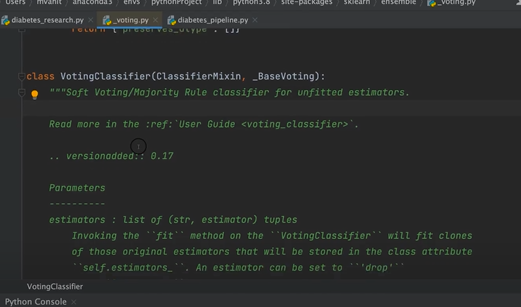

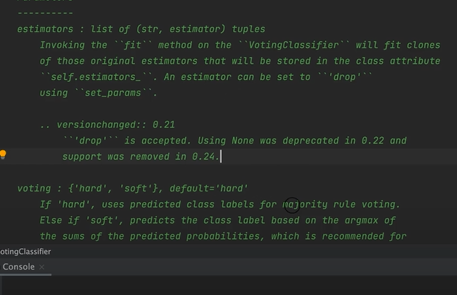

In [41]:
def voting_classifier(best_models, X, y):
    
    # Fonksiyonu çağırdığımızda yine bir raporlama olmasını bekliyoruz:
    print("Voting Classifier...")

    # VotingClassifier metodunu getiriyoruz. Bu metod der ki bana kullanack olduğun modelleri söyle, bu modellere vermek 
    # istediğin bir isimlendirme varsa onları ver. 3 tane model girdik. Daha önce oluşturmuş olduğumuz best models varya bunun
    # içerisinde bir dictionary formunda isimler var ve modeller var. Dolayısıyla best models'ın içerisinden knn ismini 
    # çağırdığımızda bu model gelecektir. Benzer şekilde diğerleri için de aynı şeyler olacaktır. 
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    # Bu üç modeli kullanarak oluşturulan votingClassifier'ın cross validation hatasına bakacağız:
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)

# Bu noktada önemli bir teorik bilgi vardır. Bu şekilde ensemble learning meta learning ya da stacking yaparken kullanılacak 
# olan modellerin aslında bir miktar birbirlerinden farklı ama olası veri seti üzerinde çok iyi bazı noktaları açıklayabiliyor
# olması beklentisi vardır teorik olarak. Dolayısıyla burada birbirinden farklı ama başarılı modelleri koymuşuz gibi 
# varsayabiliriz. Yani en başarılı 3 model bizim çalışmamızda bunlar olmayabilir. Biz burada öylesine bu üçünü koymayı tercih 
# ettik.

Voting Classifier...
Accuracy: 0.7708333333333334
F1Score: 0.636904761904762
ROC_AUC: 0.8373525905186153


### New Observation

In [42]:
######################################################
# 6. Prediction for a New Observation
######################################################

# Değişkenlerimize bir bakalım:
X.columns

# Bu veri ön işleme işlemleri sonrasındaki son halimizdir.

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_GLUCOSE_CAT_PREDIABETES', 'NEW_BMI_RANGE_HEALTY', 'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'], dtype='object')

In [43]:
# Buradan random_user diyerek bir kullanıcı seçelim:
random_user = X.sample(1, random_state=45)
random_user

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
195,0.342981,1.161295,0.770014,1.283638,1.458025,0.940144,-0.232176,-0.360847,0,1,1,0,0,1,1,0


In [44]:
# voting_clf nesnemizi çağırarak predict diyerek bu kullanıcı için diyabet tahminini gerçekleştirelim:
voting_clf.predict(random_user)

array([1], dtype=int64)

**DİKKAT :** Peki bu modeli ne yapacağız, bu geçici olaral burada mı kalacak, bu çalışma kapandığında uçacak mı? Uçmasını istemiyorsak bu modeli kaydetmemeiz gerekiyor. Onu da aşağıdaki şekilde yapıyoruz.

In [45]:
# Kaydetme:
joblib.dump(voting_clf, "voting_clf2.pkl")

['voting_clf2.pkl']

In [46]:
# Çalışıp çalışmadığını gözlemlemek için:
new_model = joblib.load("voting_clf2.pkl")

# Yüklenen modeli kullanarak tahmin işlemi gerçekleştirelim:
new_model.predict(random_user)

array([1], dtype=int64)

Biz birbirinden farklı base modelleri kullandık ve işlemimizi tamamladık. Yani hepsine genel bir baktık şöyle. Arasından en iyi birkaç tanesini seçip bunların hiperparametre optimizasyonunu gerçekleştirdik. Ondan sonra da yine seçecek olduğumuz birkaç tanesini bir araya getirerek hepsine fikrini soracağımız bir classifier oluşturduk ve bunu sakladık. Artık bu çeşitli platformlara entegre edilebilir. Çeşitli arayüzlerle web ya da mobil uygulamalarıyla konuşabilir bir forma getirildi.

**DİKKAT :** Bir machine learning pipeline bir data science pipeline süreci şu anda bizim ele aldığımız açıdan sadece core yani temel motorunu ifade etmektedir. Yani başka platformlarla konuşma, çeşitli farklı kaynaklar ile konuşma bu farklı kaynaklarla konuşma ya da çıktıları farklı kaynaklara da gönderme gibi bu işin nu pipeline'ın başka bileşenleri de vardır. Bunlar şu anda kapsamımız dahilinde olmadığından dolayı bunlar olsa dahi işin en coru aslında en zoru en yorucu kısmı olan bölümüne hazırlamış olduk. Bunun dışında ne olabilir. Farklı birkaç tane veri kaynaağı olur, iki üç tane kod ile o kaynaklara bağlanılıp veri çekilebilir. Nihayetinde elde edilen tahmin sonuçları yine bir dataframa'e bir csv'ye ya da bir sql tablosuna çevrilip başka bir platforma geri gönderilebilir. Dolayısıyla aslında biz giriş çıkış içinde kalan bütün o geniş süreci mümkün olduğu kadar kapsayıcı şekilde tamamladık. İşin en önemli kısımlarını tamamladık. Bu işlemle birlikte research bölümünü tamamlamış olduk. 